# Replication of Basten & Betz (2013) Methodology using Synthetic Data

## Introduction

This document outlines the steps taken in the provided Python script to simulate data and replicate the *methodological approach* of Basten & Betz (2013), "Beyond Work Ethic: Religion, Individual, and Political Preferences." The original paper uses a **Fuzzy Spatial Regression Discontinuity Design (RDD)** combined with **Instrumental Variables (IV)** to estimate the causal effect of Reformed Protestantism (relative to Catholicism) on preferences for leisure, redistribution, intervention, and on economic outcomes like income and inequality in Switzerland.

The core idea is to exploit a historical quasi-experiment where a previously homogeneous region in Western Switzerland was divided, with one part assigned to adopt Protestantism (by Berne) and the other remaining Catholic (under Fribourg). The historical border serves as the discontinuity cutoff. The design is "fuzzy" because being on the historically Protestant side of the border increased the likelihood of inhabitants being Protestant centuries later (in 1980, when the paper's data snapshot was taken) but did not perfectly determine it.

**Crucially, this script uses *synthetic (fake) data* generated specifically to mimic the conditions required for this analysis.** The goal is *not* to reproduce the paper's exact numerical findings, but to demonstrate *how* the Fuzzy RDD with IV estimation works in this context.

## Methodology & Code Steps

The Python script follows these key steps to simulate the data and perform the analysis:

In [1]:
# -*- coding: utf-8 -*-
"""
Replication of Basten & Betz (2013) Methodology using Synthetic Data

This script simulates data and applies a Fuzzy Spatial Regression Discontinuity
Design (RDD) with Instrumental Variables (IV) to estimate the causal effect
of a simulated treatment (inspired by Protestantism share) on various outcomes,
mimicking the approach of Basten & Betz (2013).
"""
# ==============================
# Setup: Import Libraries
# ==============================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS # For IV estimation
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme(style="whitegrid")

# For reproducibility
np.random.seed(42)

### 1. Generate Synthetic Municipality-Level Data

*   **Purpose:** Create a dataset resembling Swiss municipalities straddling the historical religious border.
*   **Variables Created:**
    *   `municipality_id`: A unique identifier for each fake municipality.
    *   `distance_km`: **The Forcing Variable.** Represents the distance of each municipality from the historical border (0 km). Negative values indicate the "Catholic" side, positive values the "Protestant" side. This variable drives the RDD.
    *   `T_historic_protestant`: **The Instrument.** An indicator variable = 1 if `distance_km >= 0` (Protestant side), and 0 otherwise. This represents the *assignment* to treatment based on the historical event, determined solely by the forcing variable.
    *   `share_protestant_1980`: **The Actual Treatment (Endogenous Variable).** Represents the proportion of Protestants in the municipality in 1980. This is generated to be:
        *   *Correlated* with the instrument `T` (there's a baseline share, plus a significant positive 'jump' in the share for municipalities where `T=1` right at the border).
        *   Influenced by `distance_km` itself (allowing for gradual trends away from the border).
        *   Subject to random noise.
        *   This construction makes the RDD *fuzzy*: `T` influences `share_protestant_1980`, but doesn't perfectly determine it.
    *   **Outcome Variables:** (`pref_leisure`, `pref_redistribution`, `pref_intervention`, `mean_income`, `income_inequality_gini`). These represent the dependent variables of interest. They are generated to depend on:
        *   The *actual* `share_protestant_1980` (this incorporates the *causal effect* we aim to estimate, with magnitudes inspired by the paper's IV results).
        *   The `distance_km` (to simulate potentially confounding spatial trends).
        *   A baseline value.
        *   Random noise.

In [2]:
# ================================================
# Step 1: Generate Synthetic Municipality-Level Data
# ================================================
print("--- Step 1: Generating Synthetic Data ---")

# --- Simulation Parameters ---
N_municipalities = 1000  # Number of synthetic municipalities
distance_range = 50      # Max distance from border in km (+/-)
border_location = 0      # The cutoff point for RDD

# Parameters for Share of Protestants (Endogenous Treatment)
base_protestant_share = 0.20  # Baseline share on Catholic side near border
treatment_jump_protestant = 0.40 # The discontinuous jump in share at the border for T=1
distance_effect_protestant = 0.001 # Gradual change in share per km away from border
noise_protestant = 0.05       # Random variation in share

# Parameters for Outcome Variables (Inspired by Basten & Betz IV results signs/relative magnitudes)
# Note: These effects represent the causal impact of ACTUAL protestant share
causal_effects = {
    'pref_leisure': -0.5,         # Protestants prefer less leisure
    'pref_redistribution': -0.4,  # Protestants prefer less redistribution
    'pref_intervention': -0.3,   # Protestants prefer less intervention
    'mean_income': 15000,         # Protestants have higher income (effect per 1 point share)
    'income_inequality_gini': 0.1 # Protestants associated with higher inequality
}
base_outcomes = { # Baseline values on Catholic side near border
    'pref_leisure': 0.5,
    'pref_redistribution': 0.6,
    'pref_intervention': 0.4,
    'mean_income': 50000,
    'income_inequality_gini': 0.3
}
distance_effect_outcome = 0.002 # How outcomes trend with distance (can vary per outcome if desired)
noise_outcome_factor = 0.1      # Factor for random variation in outcomes (relative to base)

# --- Generate Core Variables ---
df = pd.DataFrame({
    'municipality_id': range(N_municipalities)
})

# Generate distance uniformly around the border
df['distance_km'] = np.random.uniform(-distance_range, distance_range, N_municipalities)

# Generate the Instrument (Assignment based on historical border)
df['T_historic_protestant'] = (df['distance_km'] >= border_location).astype(int)

# --- Generate Endogenous Treatment (Share of Protestants in 1980) ---
# Base share + jump at border + distance trend + noise
df['share_protestant_1980'] = (
    base_protestant_share +
    df['T_historic_protestant'] * treatment_jump_protestant +
    df['distance_km'] * distance_effect_protestant +
    np.random.normal(0, noise_protestant, N_municipalities)
)
# Ensure share is between 0 and 1
df['share_protestant_1980'] = np.clip(df['share_protestant_1980'], 0, 1)

# --- Generate Outcome Variables ---
for outcome, causal_effect in causal_effects.items():
    base = base_outcomes[outcome]
    noise_level = base * noise_outcome_factor # Scale noise relative to base
    df[outcome] = (
        base +
        df['share_protestant_1980'] * causal_effect + # The CAUSAL effect of actual treatment
        df['distance_km'] * distance_effect_outcome + # Confounding distance trend
        np.random.normal(0, noise_level, N_municipalities)
    )

# Display sample data and summary statistics
print("\n--- Synthetic Data Sample (Head) ---")
print(df.head())
print("\n--- Synthetic Data Summary Statistics ---")
print(df.describe())

# Store list of outcome variables
outcome_vars = list(causal_effects.keys())

--- Step 1: Generating Synthetic Data ---

--- Synthetic Data Sample (Head) ---
   municipality_id  distance_km  T_historic_protestant  share_protestant_1980  \
0                0   -12.545988                      0               0.196339   
1                1    45.071431                      1               0.578304   
2                2    23.199394                      1               0.642209   
3                3     9.865848                      1               0.640395   
4                4   -34.398136                      0               0.193591   

   pref_leisure  pref_redistribution  pref_intervention   mean_income  \
0      0.306423             0.548843           0.309993  54340.480129   
1      0.296835             0.419835           0.303584  60132.471717   
2      0.150058             0.317323           0.212033  51179.827562   
3      0.237537             0.301051           0.180724  54713.449038   
4      0.338530             0.424535           0.291701  66679.89071

### 2. Implement the Fuzzy Spatial RDD

*   **Bandwidth Selection:** The analysis is restricted to municipalities within a specific `bandwidth` (e.g., +/- 10 km) of the border (`distance_km = 0`). RDD relies on the assumption that municipalities *just* on either side of the cutoff are comparable, except for the effect of crossing the border.
*   **Control for Forcing Variable:** The regressions include `distance_km` and an interaction term (`dist_x_T = distance_km * T_historic_protestant`). This allows the relationship between distance and the variables to differ flexibly on each side of the border, approximating a local linear regression approach near the cutoff.

In [3]:
# ================================================
# Step 2: Define RDD Controls and Apply Bandwidth
# ================================================
print("\n--- Step 2: Setting up RDD Analysis ---")

# --- RDD Setup ---
bandwidth = 10  # Use municipalities within +/- 10 km of the border

# Filter data to the bandwidth
df_rdd = df[np.abs(df['distance_km']) <= bandwidth].copy()

# Create the interaction term for flexible control of distance on either side
df_rdd['dist_x_T'] = df_rdd['distance_km'] * df_rdd['T_historic_protestant']

# Add a constant for statsmodels regressions that require it
df_rdd = sm.add_constant(df_rdd, prepend=False) # Ensure constant is added

print(f"\n--- RDD Analysis Setup ---")
print(f"Using bandwidth: +/- {bandwidth} km")
print(f"Number of observations within bandwidth: {len(df_rdd)}")
print("Created interaction term 'dist_x_T'.")
print("Added constant term for regression.")


--- Step 2: Setting up RDD Analysis ---

--- RDD Analysis Setup ---
Using bandwidth: +/- 10 km
Number of observations within bandwidth: 192
Created interaction term 'dist_x_T'.
Added constant term for regression.


### 3. Perform Econometric Analysis (IV / 2SLS)

Given the fuzzy nature (assignment `T` ≠ actual treatment `share_protestant_1980`) and the potential endogeneity of `share_protestant_1980` (unobserved factors might affect both Protestant share and outcomes), a Two-Stage Least Squares (2SLS) IV approach is necessary.

*   **a) First Stage Regression:**
    *   **Purpose:** To test the relevance of the instrument (`T_historic_protestant`). Does being on the historically Protestant side significantly predict the actual share of Protestants in 1980 near the border?
    *   **Regression:** `share_protestant_1980 ~ T_historic_protestant + distance_km + dist_x_T`
    *   **Key Output:** The coefficient on `T_historic_protestant`. It should be statistically significant and positive, representing the size of the "jump" in Protestant share at the border. Its magnitude indicates the strength of the instrument.

In [4]:
# ================================================
# Step 3a: First Stage Regression
# ================================================
print("\n--- Step 3a: Running First Stage Regression ---")

# Regress actual treatment on the instrument and controls
formula_fs = 'share_protestant_1980 ~ T_historic_protestant + distance_km + dist_x_T'
# Use 'HC1' for heteroscedasticity-consistent standard errors
first_stage_model = smf.ols(formula=formula_fs, data=df_rdd).fit(cov_type='HC1')

print("\n--- First Stage Regression Results ---")
# Specify variable order for better readability if desired
var_order_fs = ['Intercept', 'T_historic_protestant', 'distance_km', 'dist_x_T']
print(first_stage_model.summary(title="First Stage: share_protestant_1980 ~ T_historic_protestant + controls",
                                yname='share_protestant_1980', xname=var_order_fs))

# Extract the first stage coefficient for later comparison/calculation
first_stage_coef = first_stage_model.params['T_historic_protestant']
print(f"\nFirst Stage Coefficient (Jump size for T_historic_protestant): {first_stage_coef:.4f}")
print(f"First Stage F-statistic for instrument relevance: {first_stage_model.fvalue:.2f}") # F-stat for the model



--- Step 3a: Running First Stage Regression ---

--- First Stage Regression Results ---
      First Stage: share_protestant_1980 ~ T_historic_protestant + controls      
Dep. Variable:     share_protestant_1980   R-squared:                       0.949
Model:                               OLS   Adj. R-squared:                  0.948
Method:                    Least Squares   F-statistic:                     1149.
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):          1.29e-120
Time:                           22:58:29   Log-Likelihood:                 309.70
No. Observations:                    192   AIC:                            -611.4
Df Residuals:                        188   BIC:                            -598.4
Df Model:                              3                                         
Covariance Type:                     HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-

*   **b) Reduced Form Regression (Intention-to-Treat - ITT):**
    *   **Purpose:** To estimate the effect of the *assignment* (`T_historic_protestant`) directly on the outcome variables, ignoring the actual treatment level. This estimates the effect of *being intended* to be treated.
    *   **Regression:** `outcome ~ T_historic_protestant + distance_km + dist_x_T` (run separately for each outcome).
    *   **Key Output:** The coefficient on `T_historic_protestant` for each outcome. This corresponds to the results shown in Table 3 of the original paper.

In [5]:
# ================================================
# Step 3b: Reduced Form Regressions (ITT)
# ================================================
print("\n--- Step 3b: Running Reduced Form (ITT) Regressions ---")

# Regress each outcome on the instrument and controls
reduced_form_results = {}
reduced_form_coefs = {}
var_order_rf = ['Intercept', 'T_historic_protestant', 'distance_km', 'dist_x_T']

for outcome in outcome_vars:
    formula_rf = f'{outcome} ~ T_historic_protestant + distance_km + dist_x_T'
    # Use 'HC1' standard errors
    model_rf = smf.ols(formula=formula_rf, data=df_rdd).fit(cov_type='HC1')
    reduced_form_results[outcome] = model_rf
    reduced_form_coefs[outcome] = model_rf.params['T_historic_protestant']
    print(f"\n--- Reduced Form for: {outcome} ---")
    print(model_rf.summary(title=f"Reduced Form (ITT): {outcome} ~ T_historic_protestant + controls",
                           yname=outcome, xname=var_order_rf))
    print(f"Reduced Form Coefficient (ITT effect of T_historic_protestant on {outcome}): {reduced_form_coefs[outcome]:.4f}")



--- Step 3b: Running Reduced Form (ITT) Regressions ---

--- Reduced Form for: pref_leisure ---
     Reduced Form (ITT): pref_leisure ~ T_historic_protestant + controls      
Dep. Variable:           pref_leisure   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     235.0
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.41e-63
Time:                        22:58:29   Log-Likelihood:                 292.25
No. Observations:                 192   AIC:                            -576.5
Df Residuals:                     188   BIC:                            -563.5
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

*   **c) Second Stage Regression (IV / 2SLS):**
    *   **Purpose:** To estimate the *causal effect* of the *actual treatment* (`share_protestant_1980`) on the outcome variables, using the instrument (`T_historic_protestant`) to isolate exogenous variation.
    *   **Concept:** Uses the variation in `share_protestant_1980` that is *predicted* by the assignment `T` (from the first stage) to estimate the causal impact on the outcomes. This corrects for the endogeneity bias present in a simple OLS regression of `outcome` on `share_protestant_1980`.
    *   **Regression:** Conceptually `outcome ~ distance_km + dist_x_T + [share_protestant_1980 ~ T_historic_protestant + distance_km + dist_x_T]`. The script uses `statsmodels.sandbox.regression.gmm.IV2SLS`.
    *   **Key Output:** The coefficient on the instrumented `share_protestant_1980`. This is the Local Average Treatment Effect (LATE) – the average causal effect for those municipalities whose Protestant share was influenced by crossing the historical border. This corresponds to the results shown in Table 4 of the original paper. The IV estimate is typically calculated as (Reduced Form coefficient) / (First Stage coefficient).

In [6]:
# ================================================
# Step 3c: Second Stage Regressions (IV / 2SLS)
# ================================================
print("\n--- Step 3c: Running Second Stage (IV / 2SLS) Regressions ---")

# Estimate the causal effect of actual treatment using the instrument
iv_results = {}
iv_coefs = {}

# --- Define variables for IV2SLS CORRECTLY ---
# Exogenous Controls (will be part of both exog and instrument)
# Ensure 'const' column exists from sm.add_constant earlier
exog_controls = df_rdd[['const', 'distance_km', 'dist_x_T']]
# Endogenous Regressor
endog_regressor = df_rdd[['share_protestant_1980']]
# External Instrument
external_instrument = df_rdd[['T_historic_protestant']]
# Combine for the 'exog' argument of IV2SLS
all_regressors = pd.concat([exog_controls, endog_regressor], axis=1)
# Combine for the 'instrument' argument of IV2SLS
all_instruments = pd.concat([exog_controls, external_instrument], axis=1)
# --- End of variable definition correction ---

# Define variable order for IV summary tables
var_order_iv = ['const', 'distance_km', 'dist_x_T', 'share_protestant_1980']

for outcome in outcome_vars:
    print(f"\n--- IV/2SLS for: {outcome} ---")
    # Initialize IV2SLS with the corrected arguments
    model_iv = IV2SLS(endog=df_rdd[outcome],    # Dependent variable Y
                      exog=all_regressors,      # All RHS variables (controls + endogenous)
                      instrument=all_instruments) # All instruments (controls + external)

    # Fit the model WITHOUT specifying cov_type in fit() for sandbox IV2SLS
    iv_fit = model_iv.fit()

    iv_results[outcome] = iv_fit

    # Extract the coefficient for the endogenous variable ('share_protestant_1980')
    if 'share_protestant_1980' in iv_fit.params.index:
         iv_coefs[outcome] = iv_fit.params['share_protestant_1980']
    else:
        print(f"Warning: Could not find 'share_protestant_1980' in IV params for {outcome}. Params are: {iv_fit.params.index}")
        iv_coefs[outcome] = np.nan # Indicate failure

    # Display the summary. Check notes for Standard Error type.
    # Note: IV2SLS from sandbox might not report robust SEs by default in summary notes.
    print(iv_fit.summary(title=f"IV/2SLS: {outcome} ~ instrumented(share_protestant_1980) + controls",
                         yname=outcome, xname=var_order_iv))

    if not np.isnan(iv_coefs[outcome]):
        print(f"IV Coefficient (LATE of share_protestant_1980 on {outcome}): {iv_coefs[outcome]:.4f}")

        # Manual check: IV coef approx = Reduced Form Coef / First Stage Coef
        if abs(first_stage_coef) > 1e-8 :
             manual_iv_calc = reduced_form_coefs[outcome] / first_stage_coef
             print(f"Manual IV Check ({outcome}): RF Coef / FS Coef = {reduced_form_coefs[outcome]:.4f} / {first_stage_coef:.4f} = {manual_iv_calc:.4f}")
        else:
             print(f"Manual IV Check ({outcome}): Cannot perform check, First Stage Coef is near zero ({first_stage_coef:.4f})")

    else:
         print(f"Could not calculate IV Coefficient for {outcome}.")
    print("-" * 50)



--- Step 3c: Running Second Stage (IV / 2SLS) Regressions ---

--- IV/2SLS for: pref_leisure ---
    IV/2SLS: pref_leisure ~ instrumented(share_protestant_1980) + controls    
Dep. Variable:           pref_leisure   R-squared:                       0.823
Model:                         IV2SLS   Adj. R-squared:                  0.820
Method:                     Two Stage   F-statistic:                     278.1
                        Least Squares   Prob (F-statistic):           7.41e-69
Date:                Mon, 14 Apr 2025                                         
Time:                        22:58:29                                         
No. Observations:                 192                                         
Df Residuals:                     188                                         
Df Model:                           3                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------

### 4. Visualize the Discontinuities

*   **Purpose:** To graphically illustrate the discontinuities identified by the regressions.
*   **Plots:**
    *   **First Stage Plot:** Shows `share_protestant_1980` vs. `distance_km`. A clear jump (discontinuity) should be visible at `distance_km = 0`.
    *   **Reduced Form Plots:** Show each `outcome` vs. `distance_km`. Corresponding jumps or drops should be visible at `distance_km = 0`, matching the sign of the Reduced Form coefficients.


--- Step 4: Generating RDD Plots ---


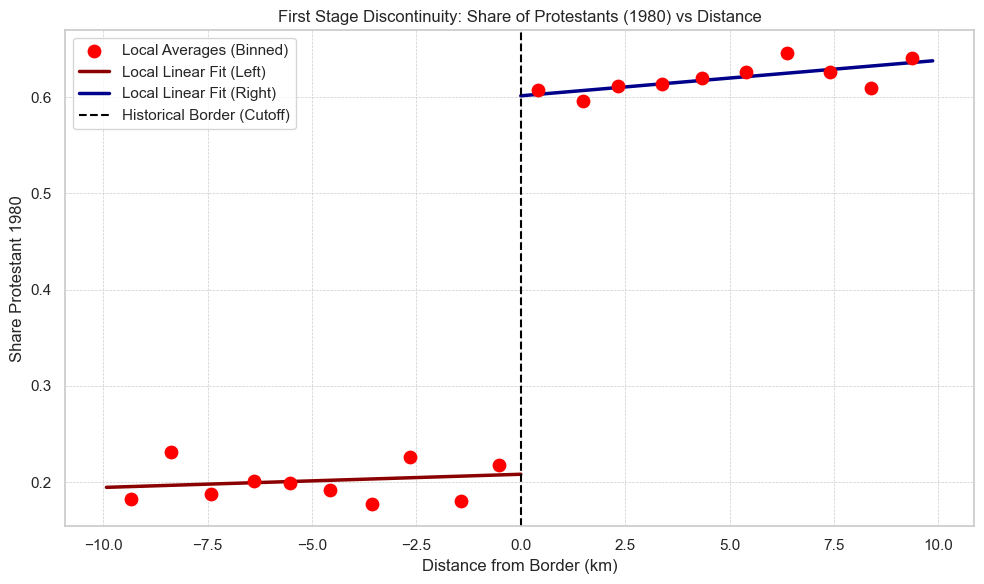

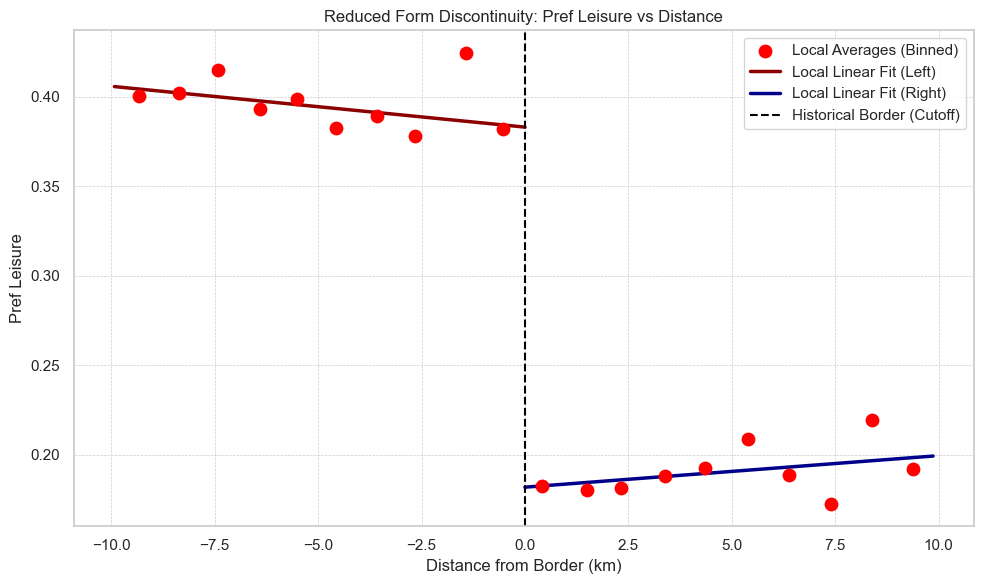

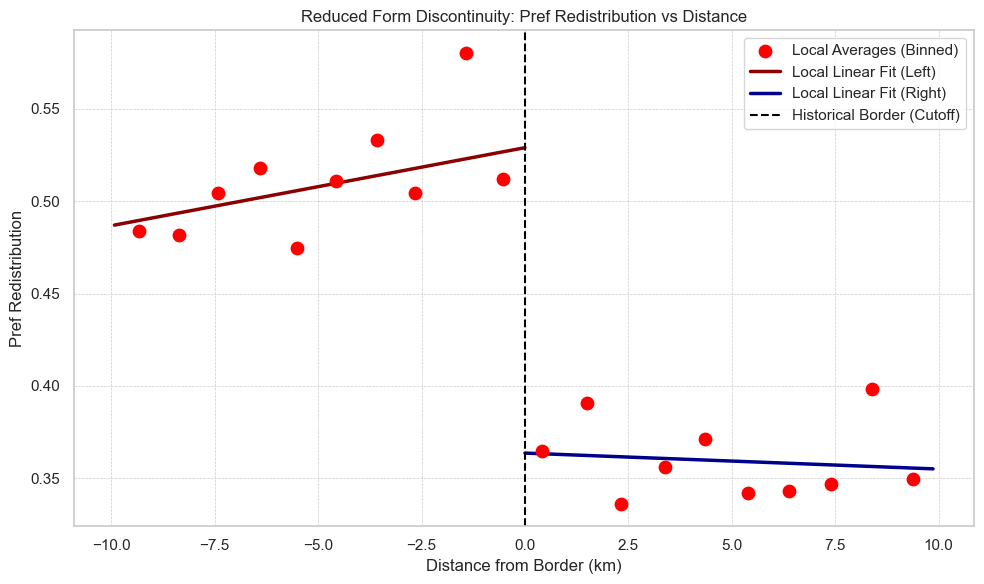

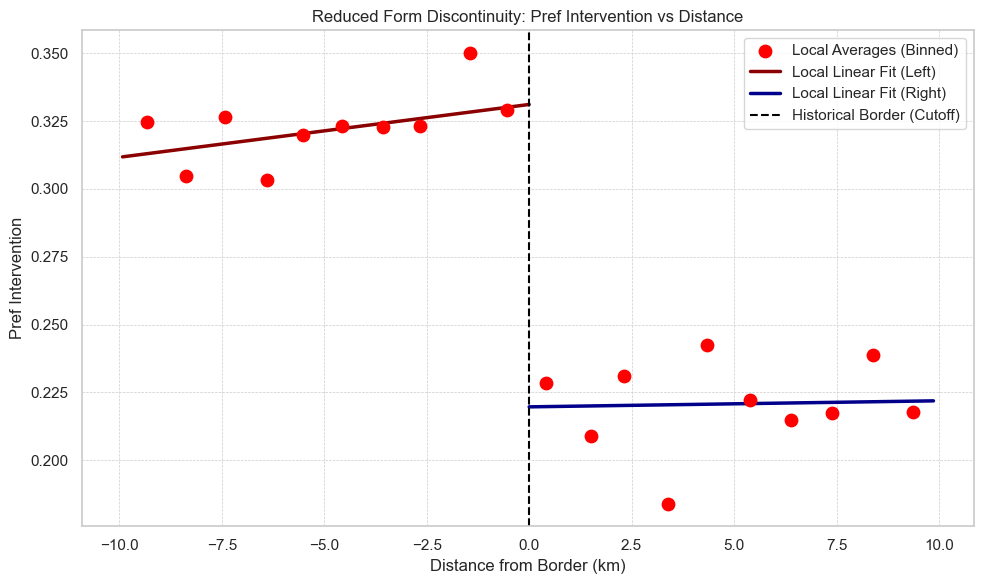

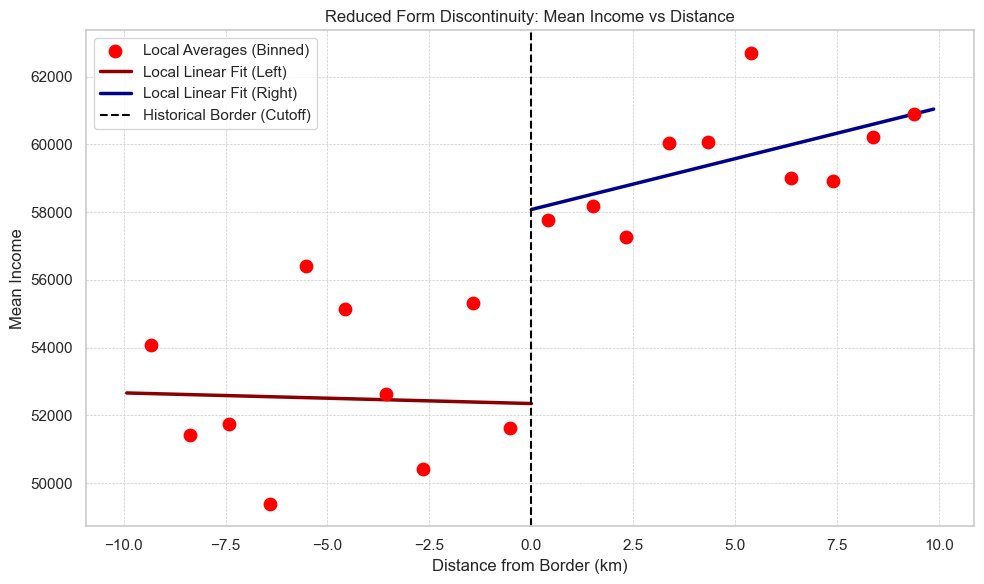

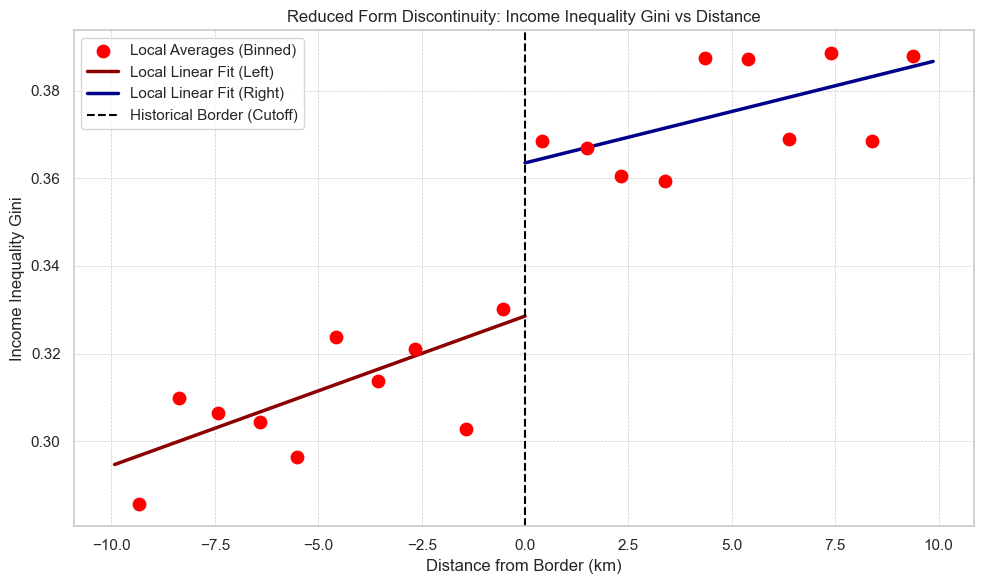


--- Plotting Complete ---

--- Script Finished ---


In [7]:
# ================================================
# Step 4: Visualize the Discontinuities
# ================================================
print("\n--- Step 4: Generating RDD Plots ---")

# Plotting function for RDD visualization (using local averages/binscatter concept)
def plot_rdd(df_full, df_rdd_analysis, y_var, x_var='distance_km', cutoff=0, bandwidth=10, n_bins=20, title=""):
    """Plots RDD visualization using binscatter and local linear fits."""
    # Use df_rdd_analysis for binning as it's already filtered by bandwidth
    df_plot = df_rdd_analysis.copy() # Work with the bandwidth-limited data for plotting fits/bins

    # Create bins based on the forcing variable within the bandwidth
    df_plot['bins'] = pd.cut(df_plot[x_var], bins=n_bins)
    bin_means = df_plot.groupby('bins', observed=False).agg(
        mean_x=(x_var, 'mean'),
        mean_y=(y_var, 'mean')
    ).dropna()

    plt.figure(figsize=(10, 6))
    # Plot raw data points within bandwidth for context (optional, can be noisy)
    # sns.scatterplot(data=df_plot, x=x_var, y=y_var, alpha=0.2, label=f'Data (+/- {bandwidth}km)')

    # Plot binned averages
    plt.scatter(bin_means['mean_x'], bin_means['mean_y'], color='red', s=80, zorder=5, label='Local Averages (Binned)')

    # Fit and plot separate lines for each side using data within the bandwidth
    data_left = df_plot[df_plot[x_var] < cutoff]
    if len(data_left) > 1:
         m_left, b_left = np.polyfit(data_left[x_var], data_left[y_var], 1)
         x_left = np.linspace(data_left[x_var].min(), cutoff, 100)
         plt.plot(x_left, m_left*x_left + b_left, color='darkred', lw=2.5, label='Local Linear Fit (Left)')

    data_right = df_plot[df_plot[x_var] >= cutoff]
    if len(data_right) > 1:
        m_right, b_right = np.polyfit(data_right[x_var], data_right[y_var], 1)
        x_right = np.linspace(cutoff, data_right[x_var].max(), 100)
        plt.plot(x_right, m_right*x_right + b_right, color='darkblue', lw=2.5, label='Local Linear Fit (Right)')


    plt.axvline(x=cutoff, color='black', linestyle='--', lw=1.5, label='Historical Border (Cutoff)')
    plt.xlabel("Distance from Border (km)")
    plt.ylabel(y_var.replace('_', ' ').title()) # Nicer label
    plt.title(title)
    plt.legend()
    plt.grid(True, which='major', linestyle='--', linewidth='0.5')
    plt.tight_layout() # Adjust layout
    plt.show()

# 1. First Stage Plot
plot_rdd(df, df_rdd, 'share_protestant_1980', bandwidth=bandwidth, n_bins=20,
         title='First Stage Discontinuity: Share of Protestants (1980) vs Distance')

# 2. Reduced Form Plots
for outcome in outcome_vars:
    plot_rdd(df, df_rdd, outcome, bandwidth=bandwidth, n_bins=20,
             title=f'Reduced Form Discontinuity: {outcome.replace("_", " ").title()} vs Distance')

print("\n--- Plotting Complete ---")
print("\n--- Script Finished ---")